In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

In [2]:
sns.set_context("talk")
sns.set_style('whitegrid')
sns.set_palette('deep')

In [3]:
import matplotlib.style as style 
style.use('seaborn-poster')
style.use('ggplot')


In [111]:
df = pd.read_csv('../data/processed/got.csv')
df.shape

(25058, 7)

In [5]:
df.head()

,character,episode,episode_name,scene,season,text,rate
0,WAYMAR ROYCE,1,Winter Is Coming,1,1,What d’you expect? They’re savages. One lot s...,9.1
1,WILL,1,Winter Is Coming,1,1,I’ve never seen wildlings do a thing like thi...,9.1
2,WAYMAR ROYCE,1,Winter Is Coming,1,1,How close did you get?,9.1
3,WILL,1,Winter Is Coming,1,1,Close as any man would.,9.1
4,GARED,1,Winter Is Coming,1,1,We should head back to the wall.,9.1


In [112]:
df['character'] =  df['character'].str.title()
# remove surname to unify character names
df['character'] = df['character'].apply(lambda name: name.split()[0])
# removing character called 'Man' that it's a generic character and it isn't relevant for the analysis
no_name_chars = df['character'] == 'Man'
df = df[~no_name_chars]

In [7]:
n_characters = df['character'].nunique()
print('Number of unique characters in the show:', n_characters)

Number of unique characters in the show: 645


There are more than one thousand characters across the lines of dialogue. In the first place, we are going to select a subset of the characters to be able to visualize them. 

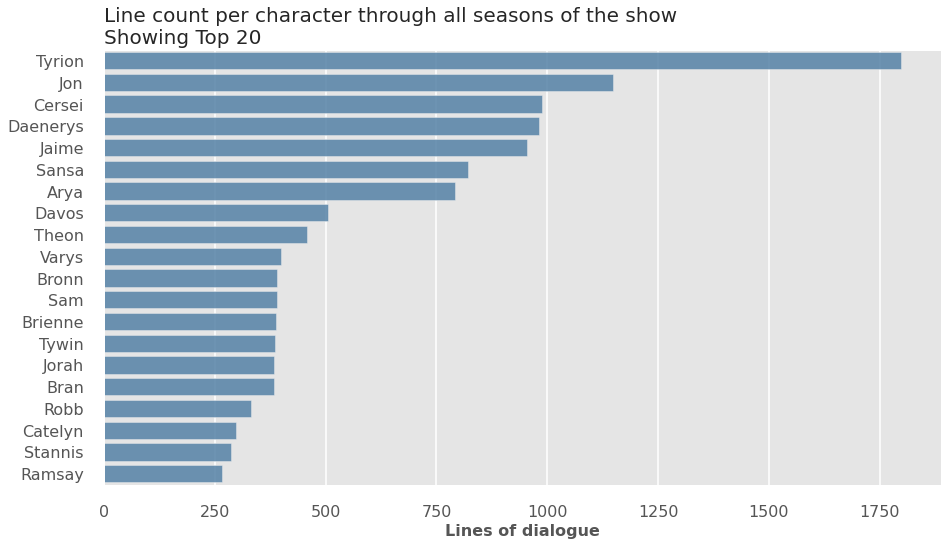

In [8]:
# lines counts by each character
n_lines = df['character'].value_counts()[:20]
plt.figure(figsize=(15, 8))
sns.barplot(x = n_lines, y=n_lines.index, color="steelblue", alpha=.85);
plt.title('Line count per character through all seasons of the show\nShowing Top 20',
          fontsize=20, horizontalalignment='left', loc='left')

plt.xlabel('Lines of dialogue', fontsize=16, weight='bold');


* It is clear that Tyrion is the one who said the most lines of dialogue throughout the series.
* The following with a high counter are Jon Snow, Cersei, Daenerys, Jaime, Sansa and Arya. Basically these were the character that survive all the seasons and they were of major importance in the plot

Now, let's check how are the lines count by season. This will give us an idea of how the presence of each character evolved throughout the series.

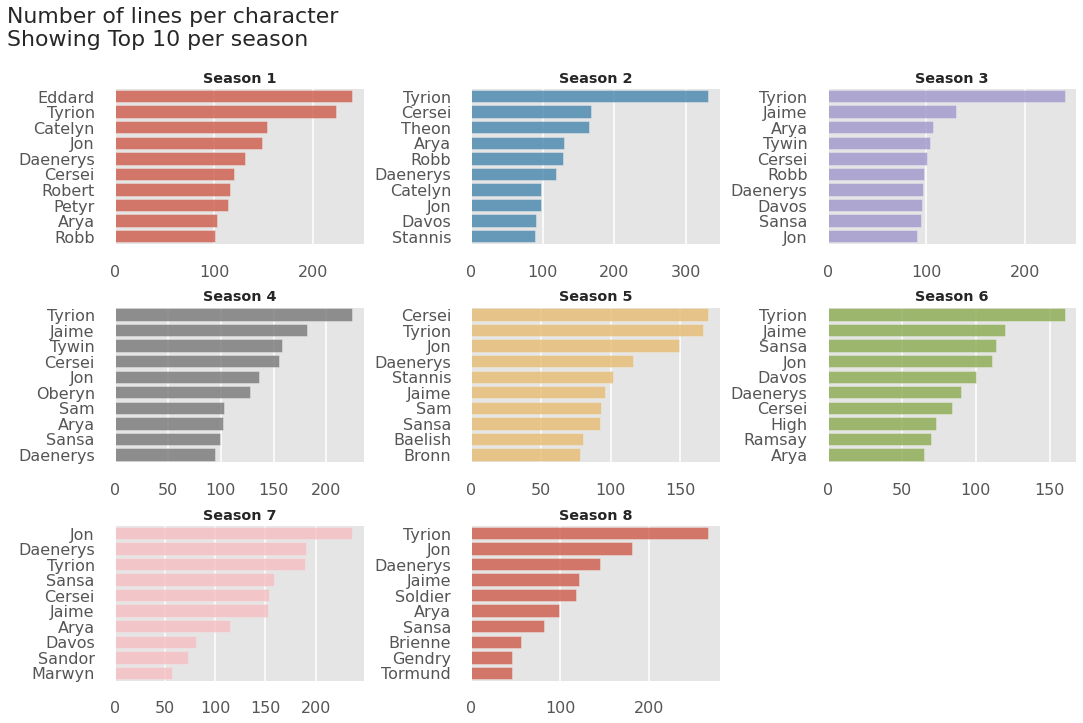

In [9]:
lines_by_season = df.groupby('season')['character'].value_counts() \
                    .groupby(level=0).head(10).rename('count').reset_index()

fig, axes = plt.subplots(3, 3, figsize=(15,10))
axes = axes.ravel()
colors = plt.rcParams["axes.prop_cycle"]()
for i in range(8):
    c = next(colors)['color']
    i_season = lines_by_season[lines_by_season['season'] == i+1]
    sns.barplot(x='count', y='character', data=i_season, ax=axes[i], color=c, alpha=.8);
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(f'Season {i+1}', weight='bold')
axes[-1].set_axis_off()
fig.suptitle('Number of lines per character\nShowing Top 10 per season',
             fontsize=22, horizontalalignment='left',
            x=0, y=1)

plt.tight_layout();

* The most repeated characters are: Tyrion, Jon Snow, Daenerys, Jaime and Arya
* It's surprising how Tyrion is in the top 2 in all seasons.
* Jon is a character with a large presence in the first season. However, in the following seasons he stands out a little less. And in the last two he is again one of the characters with more dialogue.
* Daenerys, like Jon, has more lines of dialogue as ending approaches.
* There are characters that have many lines in some seasons but then disappear in the following ones. This is the case of characters like Eddard, Tywin, Robb or Cersei, which die during the course of the show.

As we can see Game of Thrones has many characters and the spotlight is fairly evenly distributed throughout the series with the exception of Tyrion who always stands out. 
\
\
Now that we know which people we’ll be working with, we can start doing some text analysis.

## Word Frequency

Let's take a look at which words are the most used by each character.

In [13]:
df['text']

0         What d’you expect? They’re savages. One lot s...
1         I’ve never seen wildlings do a thing like thi...
2                                   How close did you get?
3                                  Close as any man would.
4                         We should head back to the wall.
                               ...                        
25052        Well, I imagine he isn't using them properly.
25053     I think we can all agree that ships take prec...
25054        I think that's a very presumptuous statement.
25055     I once brought a jackass and a honeycomb into...
25057     The Queen in the North! The Queen in the Nort...
Name: text, Length: 24639, dtype: object

We are goint to create a dictionary to store word counts for each character

In [31]:
nltk.word_tokenize('hola mi nombre es predo. Es asi')

['hola', 'mi', 'nombre', 'es', 'predo', '.', 'Es', 'asi']

In [131]:
"""
Dict structure.

word_counter = {
    key: character_name
    value: {
        key: word root,
        value: (word, count)
    }
}
"""
stemmer = nltk.stem.snowball.SnowballStemmer('english')
stopwords = nltk.corpus.stopwords.words('english')


def get_counter(lines):
    word_counter = {}
    for token in nltk.word_tokenize(lines):
        word = token.lower()
        if not word.isalpha() or word in stopwords:
            continue
        else:
            root = stemmer.stem(word)
            if root in word_counter.keys():
                word_counter[root]['count'] += 1
                if len(word) < len(word_counter[root]['word']):
                    word_counter[root]['word'] = word
            else:
                word_counter[root] = {'count': 1,'word': word}
    return word_counter
        

def get_word_counter(df, character_name):
    
    
    dialogue_lines = df[df['character'] == character_name]['text'].copy()
    
    lines_string = ' '.join(dialogue_lines.astype(str).to_list())
    
   
    counter = get_counter(lines_string)
    word_counts = [(value['word'],value['count']) for value  in counter.values()] 
    word_counts.sort(key=lambda x: x[1], reverse=True)
    return word_counts
    


In [134]:
# We just show top 12 character with more lines.


character_name = 'Jon'

word_counts = get_word_counter(df, character_name)
word_counts[:5]

[('know', 98), ('want', 62), ('come', 59), ('go', 56), ('need', 51)]

In [121]:
pd.DataFrame(word_counts, columns=['word', 'counts']).head()

,word,counts
0,know,130
1,want,119
2,would,103
3,one,102
4,king,99


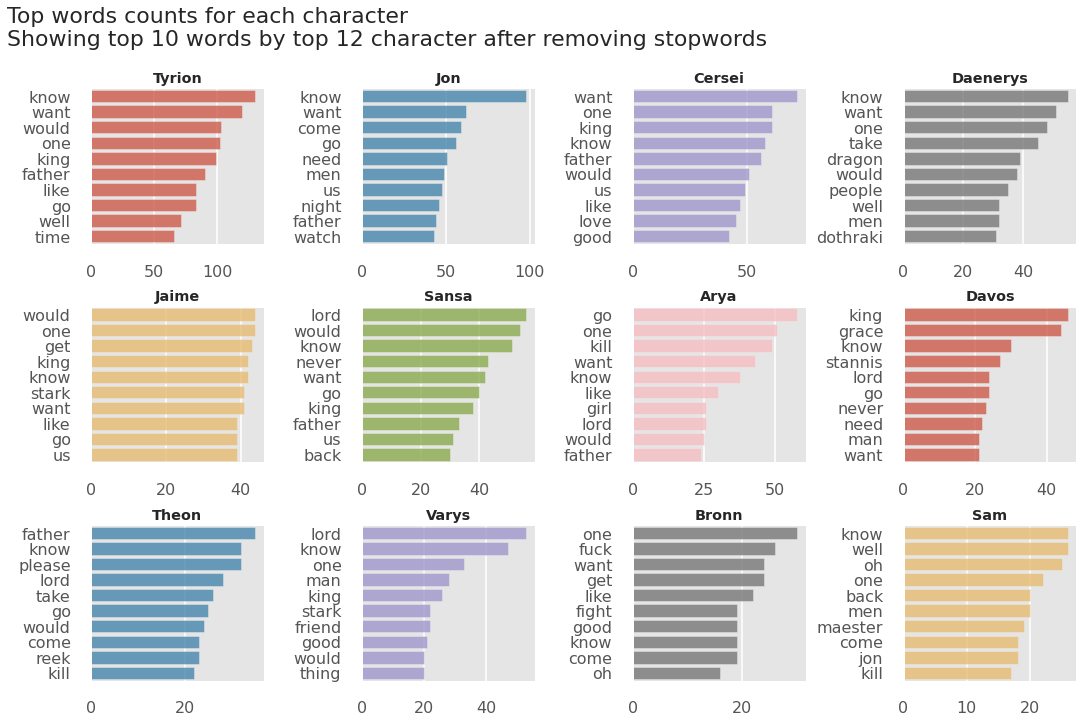

In [139]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
colors = plt.rcParams["axes.prop_cycle"]()
axes = axes.ravel()

characters = ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa',
              'Arya', 'Davos', 'Theon', 'Varys', 'Bronn', 'Sam']

for i, character in enumerate(characters):
    c = next(colors)['color']
    word_counts = get_word_counter(df, character)
    word_count_df = pd.DataFrame(word_counts, columns=['word', 'count'])
    sns.barplot(x='count', y='word', data=word_count_df[:10], ax=axes[i], color=c, alpha=.8);
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(f'{character}', weight='bold')
    
fig.suptitle('Top words counts for each character\nShowing top 10 words by top 12 character after removing stopwords',
             fontsize=22, horizontalalignment='left', x=0, y=1) 
plt.tight_layout()